# Assignment 2

**Submission deadline: last lab session before or on Thursday, 26.03.2020**

**Points: 6 + 1 bonus points**

## Submission instructions
The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment2_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restart and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook with your instructor using his `cs.uni.wroc.pl` email

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D` matrix.

Text(0, 0.5, 'X[1]')

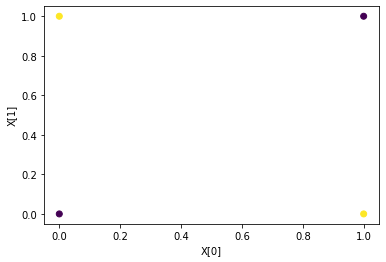

In [0]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1],
    ], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array(
    [[0],
     [1],
     [1],
     [0],
    ], dtype=np.float32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0], )
plt.xlabel('X[0]')
plt.ylabel('X[1]')

# Problem 1 [2p]

Fill in the details of a forward pass, then manually set the weights and biases in the network to solve the 2D XOR task defined above.

In [0]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32, activate_func=sigmoid):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.activate_func = activate_func
        self.init_params()

    def init_params(self):
        # TODO Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.normal(0, 0.5, self.W1.shape)
        self.b1 = np.random.normal(0, 0.5, self.b1.shape)
        self.W2 = np.random.normal(0, 0.5, self.W2.shape)
        self.b2 = np.random.normal(0, 0.5, self.b2.shape)

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # # Input to neurons in 1st layer
        A1 = np.dot(X, self.W1.T) + self.b1

        # # Outputs after the sigmoid non-linearity
        O1 = self.activate_func(A1)

        # # Inputs to neuron in the second layer
        A2 = np.dot(O1, self.W2.T) + self.b2

        # # Outputs after the sigmoid non-linearity
        O2 = self.activate_func(A2)

        if Y is not None:
            loss = -Y*np.log(O2 + 1e-20) - (1-Y)*np.log(1-O2 + 1e-20)
            
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2: fill in the gradient computation
            # Please note, that there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss 
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.T.sum(axis=1)
            self.b2_grad /= X.shape[0]
            self.W2_grad = np.dot(A2_grad.T, O1)
            self.W2_grad /= X.shape[0]
            
            O1_grad = np.dot(A2_grad, self.W2)
            A1_grad = O1_grad * O1 * (np.ones(O1.shape) - O1)
            self.b1_grad = A1_grad.sum(axis=0) 
            self.b1_grad /= X.shape[0]
            self.W1_grad = np.dot(X.T, A1_grad).T
            self.W1_grad /= X.shape[0]

        return O2, loss

In [0]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)

net.W1 = np.ones((2,2)) * 40
net.b1 = np.array([-1,-2.5]) * 20
net.W2 = np.array([[1,-1]]) * 40
net.b2 = np.array([-1]) * 20 

# Hint: since we use the logistic sigmoid activation, the weights may need to 
# be fairly large 

net.forward(X, Y, do_backward=True)

(array([[2.06115379e-09],
        [9.99999998e-01],
        [9.99999998e-01],
        [2.06115362e-09]]), 2.063026862582939e-09)

# Problem 2 [2p]

1. Fill in the backward pass.
2. Implement random initialization of network parameters.
3. Using `float64` verify correctness of your backward pass.

In [0]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""
    
    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + '_grad')
    assert (param.shape == orig_grad.shape)

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (
            loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [0]:
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ['W1', 'b1', 'W2', 'b2']:
    check_grad(net, param_name, X, Y)

# Problem 3 [2p]

Fill in the details of batch gradient descent below, then train a network to solve 2D XOR problem.

Then test the reliability of solving the 3D XOR task.

In [0]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        grad = getattr(net, param_name + '_grad')
        param[:] = param[:] - alpha * grad

0 0.7182378852440441
5000 0.04142092623066047
10000 0.010555237423259613
15000 0.005724731082606601
20000 0.0038535574749833544
25000 0.002875756701647397
30000 0.002279852370453057
35000 0.001880760725155274
40000 0.0015958270735295212
45000 0.0013827623289844352
50000 0.0012177539835130562
55000 0.0010864008551264668
60000 0.0009794974310324222
65000 0.0008908930066557375
70000 0.0008163263690735018
75000 0.0007527548233708288
80000 0.0006979494635119083
85000 0.00065024129137279
90000 0.0006083565438726876
95000 0.0005713067489624625


In [0]:
net.forward(X, Y, do_backward=True)

(array([[3.23594384e-04],
        [9.99438003e-01],
        [9.99492708e-01],
        [7.59742960e-04]]), 0.0005383134440106893)

Generate below data for a 3D XOR task. Try a few values of hidden layer size. Plot the reliability of training, i.e. how many trainings succeed for a given hiden layer size.

What is easier to train: a smaller, or large network?

In [0]:
losses = {}
X3 = np.array(np.meshgrid([0, 1], [0, 1], [0, 1])).reshape(8, 3)
Y3 = np.array([x.sum()%2 for x in X3]).reshape(1,-1).T

iters = 100000
x_progress = np.linspace(0, iters, 20).astype(int)

for hidden_dim in tqdm([2, 3, 5, 10, 20], position=0, leave=True):
    # TODO: run a few trainings and record the fraction of successful ones
    net = SmallNet(3, hidden_dim, dtype=np.float64)
    loss_progress = []
    for i in range(iters):
        _, loss = net.forward(X3, Y3, do_backward=True)
        if i in x_progress:
            loss_progress.append(loss)
        for param_name in ['W1', 'b1', 'W2', 'b2']:
            param = getattr(net, param_name)
            grad = getattr(net, param_name + '_grad')
            param[:] = param[:] - alpha * grad 

    _, loss = net.forward(X3, Y3, do_backward=True)
    loss_progress.append(loss)
    losses[hidden_dim] = loss_progress

100%|██████████| 5/5 [00:49<00:00,  9.89s/it]


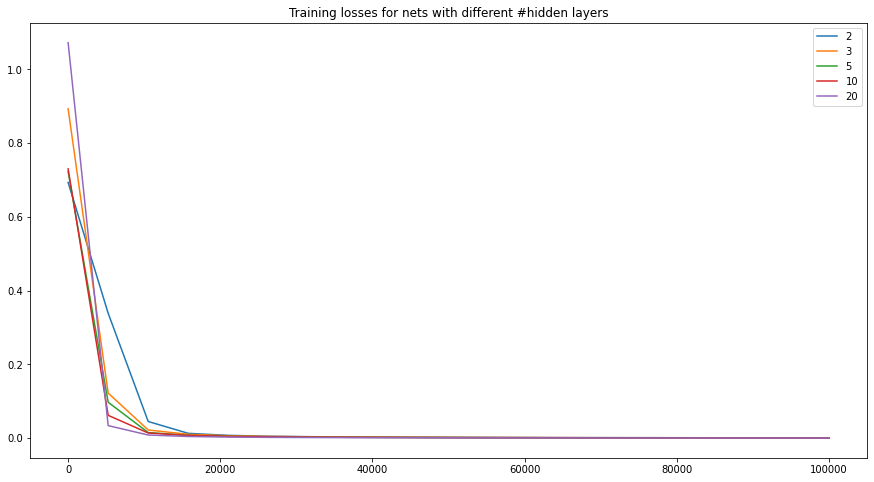

In [0]:
plt.subplots(figsize=(15, 8))
plt.title('Training losses for nets with different #hidden layers')
for hd in losses.keys():
    plt.plot(x_progress, losses[hd], label=hd)
plt.legend()
plt.show()

# Problem 4 [1bp]

Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Verify ho

In [0]:
def relu(x):
    return np.max((np.zeros_like(x), x), axis=0)

In [0]:
net = SmallNet(2, 2, dtype=np.float64, activate_func=relu)

net.W1 = np.ones((2,2))
net.b1 = np.array([0, -1])
net.W2 = np.array([[1,-2]])
net.b2 = np.array([0])

net.forward(X, Y, do_backward=True)

(array([[0.],
        [1.],
        [1.],
        [0.]]), 0.0)

In [0]:
net = SmallNet(2, 2, dtype=np.float64, activate_func=relu)

In [0]:
for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        grad = getattr(net, param_name + '_grad')
        param[:] = param[:] - 0.01 * grad

0 23.025850929940457
5000 0.44825942922365997
10000 0.35602856533250815
15000 0.3472692012614711
20000 0.3466236617600181
25000 0.3465771887231357
30000 0.3465738488560995
35000 0.34657360886052296
40000 0.3465735916151169
45000 0.3465735903759125
50000 0.3465735902868672
55000 0.34657359028047097
60000 0.34657359028007784
65000 0.34657359028007784
70000 0.34657359028007784
75000 0.34657359028007784
80000 0.34657359028007784
85000 0.34657359028007784
90000 0.34657359028007784
95000 0.34657359028007784


In [0]:
net.forward(X, Y, do_backward=True)

(array([[9.11493103e-14],
        [5.00000000e-01],
        [1.00000000e+00],
        [5.00000000e-01]]), 0.34657359028007784)